### Refinery Efficiency and Emission Monitoring System

####

1. Business Objective
To improve operational efficiency and environmental compliance across refinery units by analyzing production, downtime, energy use, and emissions.

2. Problem Statement
Manual tracking and siloed systems make it hard to spot inefficiencies, forecast equipment issues, or ensure optimal performance across refinery units. There's also a need to detect patterns contributing to increased sulfur emissions and unplanned downtimes.

3. Business Questions

   i. What are the key drivers of high sulfur emissions?

   ii. Which units and shifts have the highest downtime or inefficiencies?

   iii. How does energy consumption relate to production efficiency?

   iv. Can we predict potential maintenance issues before they occur?

5. Key Deliverables

   . EDA report highlighting inefficiencies, correlations, and anomalies

   . Predictive model for maintenance or downtime risk

   . Emission trend dashboard by unit and shift

   . Operational performance benchmarking tool

   . Custom recommendations for reducing sulfur emissions and improving uptime

#### 1. Initial Setup and Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Load the dataset
df = pd.read_csv('refinery_dataset.csv', parse_dates=['Date'])

In [2]:
# Display basic info
df.shape

(500, 10)

In [3]:
df.head()

Refinery_ID       Date  Crude_Processed_BPD  Production_Efficiency  \
0      REF003 2024-01-01               141532              94.132880   
1      REF004 2024-01-02               134851              93.332790   
2      REF001 2024-01-03               145534              90.917102   
3      REF003 2024-01-04               158563              95.477989   
4      REF003 2024-01-05               152140              88.756810   

   Energy_Consumption_MWh  Maintenance_Issues  Downtime_Hours  \
0                    2082                   2            1.33   
1                    1854                   3            4.27   
2                    2015                   2            2.18   
3                    1799                   0            4.03   
4                    1909                   4            2.69   

   Sulfur_Emission_PPM           Unit Operator_Shift  
0                46.17   Distillation            Day  
1                48.76  Hydrotreating          Night  
2                46.02  Hydrotreating          Night  
3                38.16   Distillation            Day  
4                46.00      Reforming            Day

In [4]:
df.describe().T

count                 mean                  min  \
Date                      500  2024-09-06 12:00:00  2024-01-01 00:00:00   
Crude_Processed_BPD     500.0           149932.012             117587.0   
Production_Efficiency   500.0            92.333851                 85.0   
Energy_Consumption_MWh  500.0             2009.224               1561.0   
Maintenance_Issues      500.0                 2.02                  0.0   
Downtime_Hours          500.0              3.09536                 0.04   
Sulfur_Emission_PPM     500.0             49.22722                19.92   

                                        25%                  50%  \
Date                    2024-05-04 18:00:00  2024-09-06 12:00:00   
Crude_Processed_BPD                142910.0             149898.5   
Production_Efficiency             90.334193            92.445523   
Energy_Consumption_MWh               1906.0               2004.5   
Maintenance_Issues                      1.0                  2.0   
Downtime_Hours                       1.4675                 2.61   
Sulfur_Emission_PPM                   42.82                49.27   

                                        75%                  max           std  
Date                    2025-01-09 06:00:00  2025-05-14 00:00:00           NaN  
Crude_Processed_BPD                156520.5             188527.0  10083.156585  
Production_Efficiency             94.205888            99.897146      2.940117  
Energy_Consumption_MWh               2104.5               2478.0    149.838623  
Maintenance_Issues                      3.0                  7.0      1.442137  
Downtime_Hours                        4.135                15.51      2.203498  
Sulfur_Emission_PPM                  55.605                81.52     10.039656

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Refinery_ID             500 non-null    object        
 1   Date                    500 non-null    datetime64[ns]
 2   Crude_Processed_BPD     500 non-null    int64         
 3   Production_Efficiency   500 non-null    float64       
 4   Energy_Consumption_MWh  500 non-null    int64         
 5   Maintenance_Issues      500 non-null    int64         
 6   Downtime_Hours          500 non-null    float64       
 7   Sulfur_Emission_PPM     500 non-null    float64       
 8   Unit                    500 non-null    object        
 9   Operator_Shift          500 non-null    object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(3)
memory usage: 39.2+ KB


In [6]:
df.isnull().sum()

Refinery_ID               0
Date                      0
Crude_Processed_BPD       0
Production_Efficiency     0
Energy_Consumption_MWh    0
Maintenance_Issues        0
Downtime_Hours            0
Sulfur_Emission_PPM       0
Unit                      0
Operator_Shift            0
dtype: int64

#### 2. Exploratory Data Analysis (EDA)

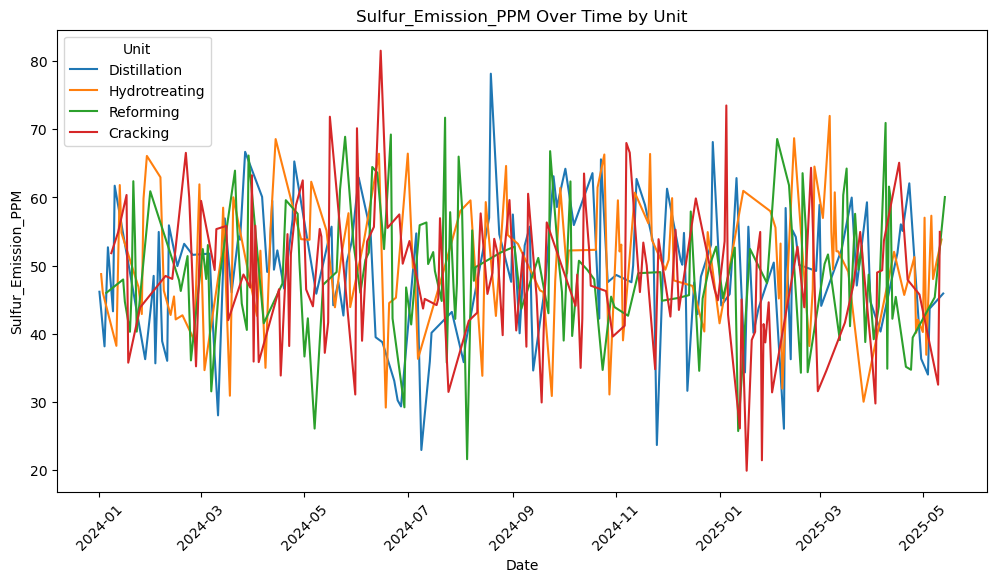

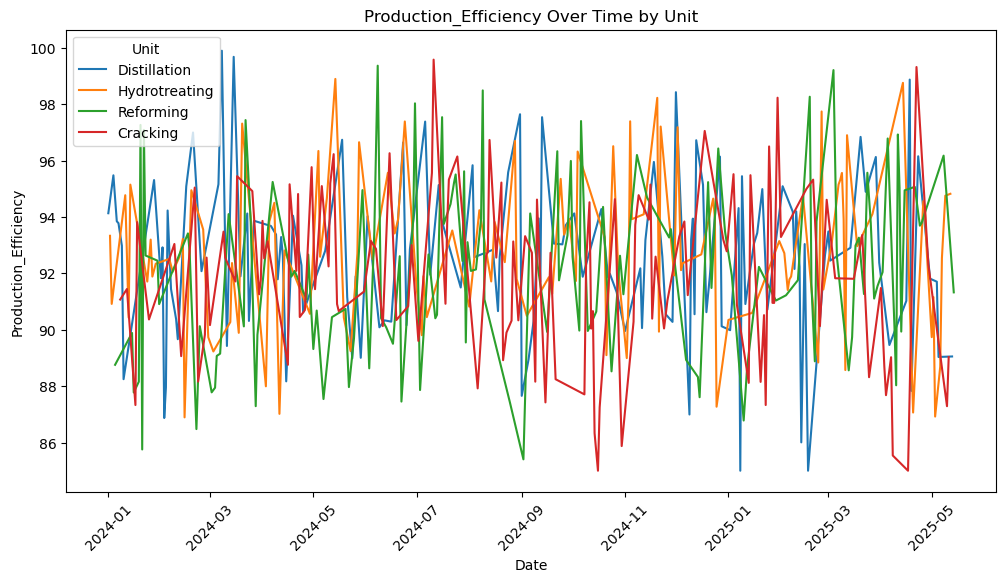

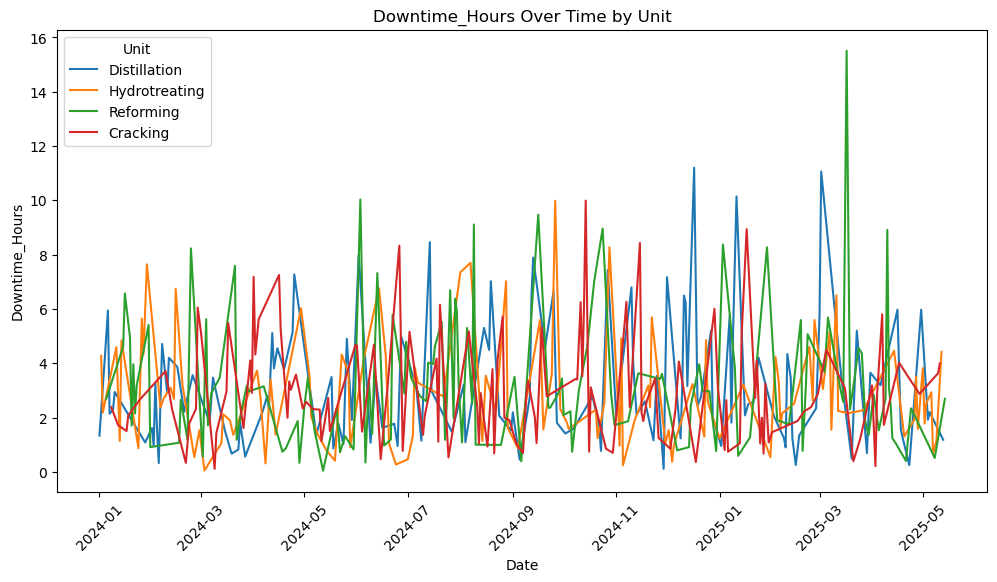

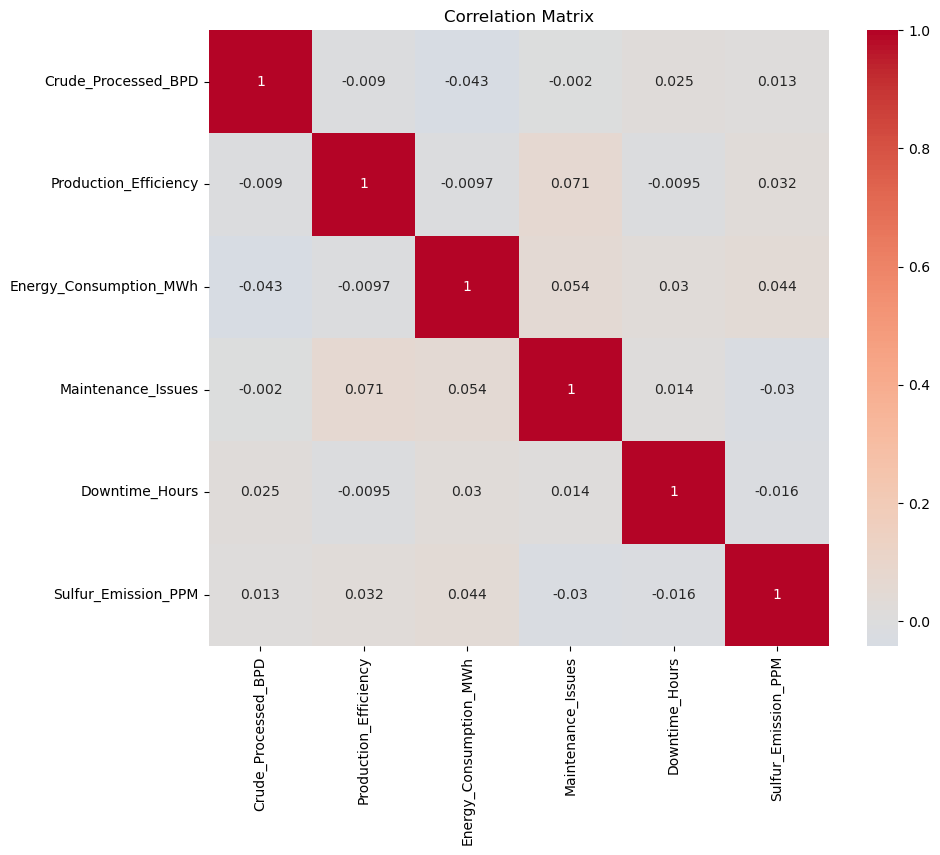

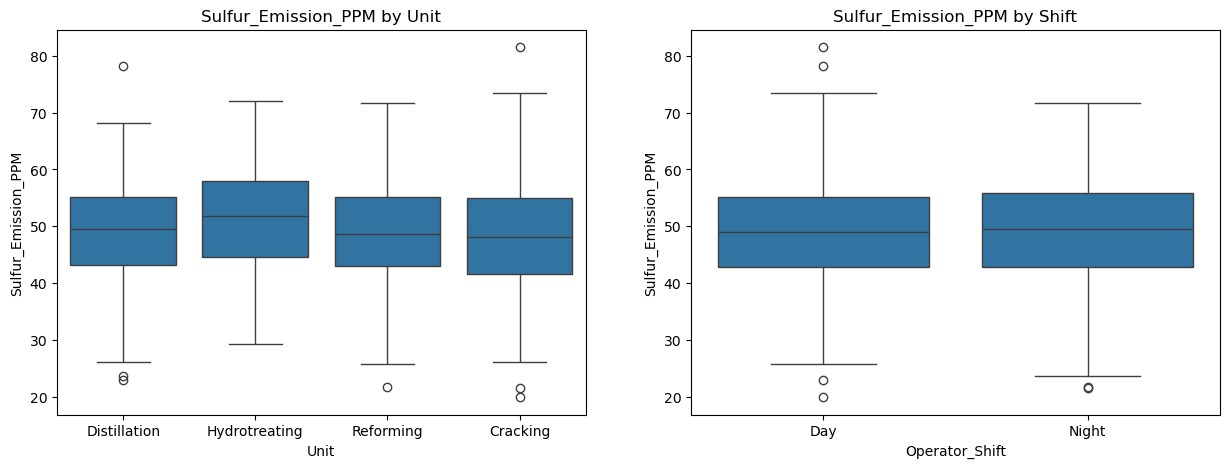

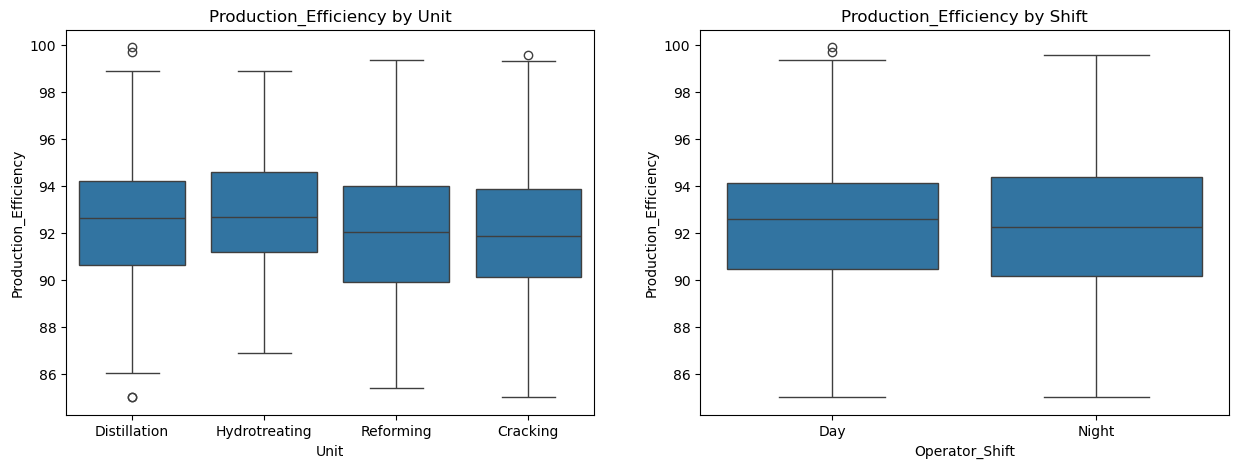

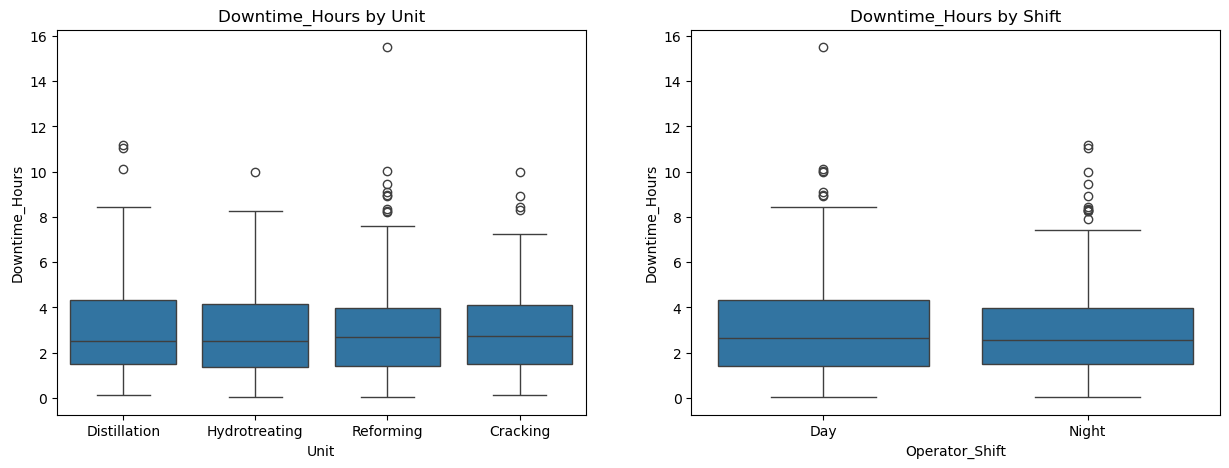

Anomalies in Sulfur_Emission_PPM: 1
Anomalies in Production_Efficiency: 0
Anomalies in Downtime_Hours: 7


In [7]:
# 1. Time series analysis of key metrics
def plot_time_series(metric):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Date', y=metric, hue='Unit')
    plt.title(f'{metric} Over Time by Unit')
    plt.xticks(rotation=45)
    plt.show()

plot_time_series('Sulfur_Emission_PPM')
plot_time_series('Production_Efficiency')
plot_time_series('Downtime_Hours')

# 2. Correlation analysis
plt.figure(figsize=(10, 8))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.show()

# 3. Distribution of key metrics by unit and shift
def plot_distribution(metric):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(data=df, x='Unit', y=metric, ax=axes[0])
    axes[0].set_title(f'{metric} by Unit')
    sns.boxplot(data=df, x='Operator_Shift', y=metric, ax=axes[1])
    axes[1].set_title(f'{metric} by Shift')
    plt.show()

plot_distribution('Sulfur_Emission_PPM')
plot_distribution('Production_Efficiency')
plot_distribution('Downtime_Hours')

# 4. Anomaly detection
def detect_anomalies(metric, threshold=3):
    mean = df[metric].mean()
    std = df[metric].std()
    df[f'{metric}_Anomaly'] = np.abs(df[metric] - mean) > threshold * std
    print(f"Anomalies in {metric}: {df[f'{metric}_Anomaly'].sum()}")

detect_anomalies('Sulfur_Emission_PPM')
detect_anomalies('Production_Efficiency')
detect_anomalies('Downtime_Hours')

#### 3.1 Key drivers of high sulfur emissions

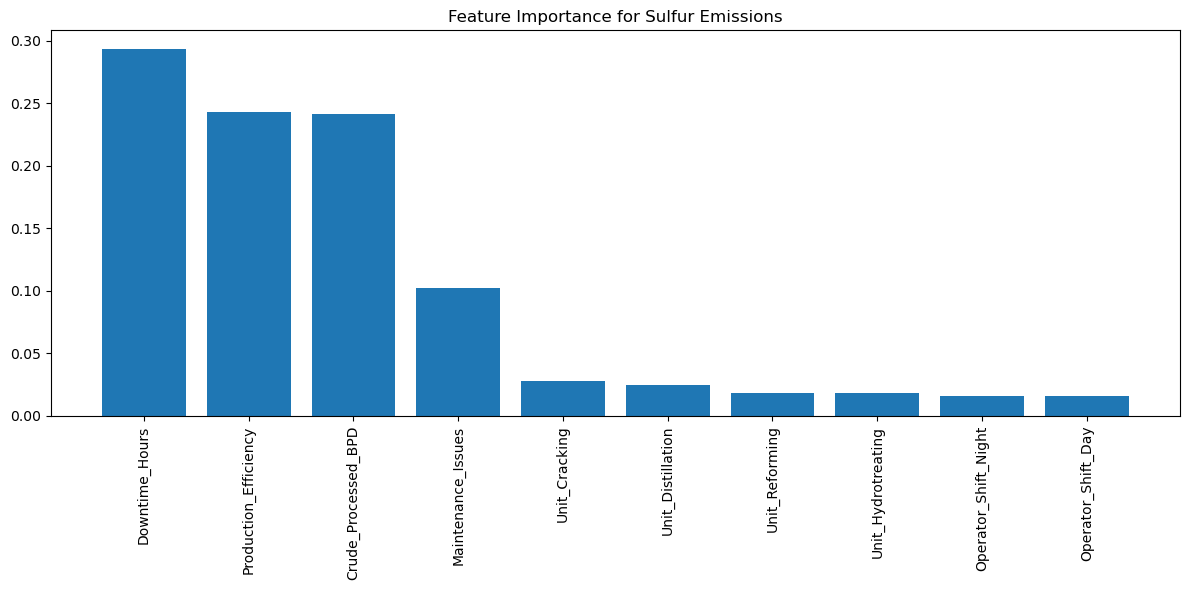

In [8]:
# Feature importance for sulfur emissions
sulfur_df = df.dropna(subset=['Sulfur_Emission_PPM']).copy()

# Prepare features and target
X = sulfur_df[['Crude_Processed_BPD', 'Production_Efficiency', 'Maintenance_Issues', 
               'Downtime_Hours', 'Unit', 'Operator_Shift']]
X = pd.get_dummies(X)  # Convert categorical variables
y = sulfur_df['Sulfur_Emission_PPM']

# Train a model to find important features
model = RandomForestRegressor()
model.fit(X, y)

# Plot feature importance
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance for Sulfur Emissions')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

#### 3.2 Units and shifts with highest downtime or inefficiencies

In [9]:
# Group by Unit and Shift
unit_shift_perf = df.groupby(['Unit', 'Operator_Shift']).agg({
    'Production_Efficiency': 'mean',
    'Downtime_Hours': 'mean',
    'Sulfur_Emission_PPM': 'mean'
}).reset_index()

# Visualize
fig = px.bar(unit_shift_perf, x='Unit', y='Downtime_Hours', color='Operator_Shift',
             barmode='group', title='Average Downtime Hours by Unit and Shift')
fig.show()

fig = px.bar(unit_shift_perf, x='Unit', y='Production_Efficiency', color='Operator_Shift',
             barmode='group', title='Average Production Efficiency by Unit and Shift')
fig.show()

#### 3.3 Energy consumption relation to production efficiency

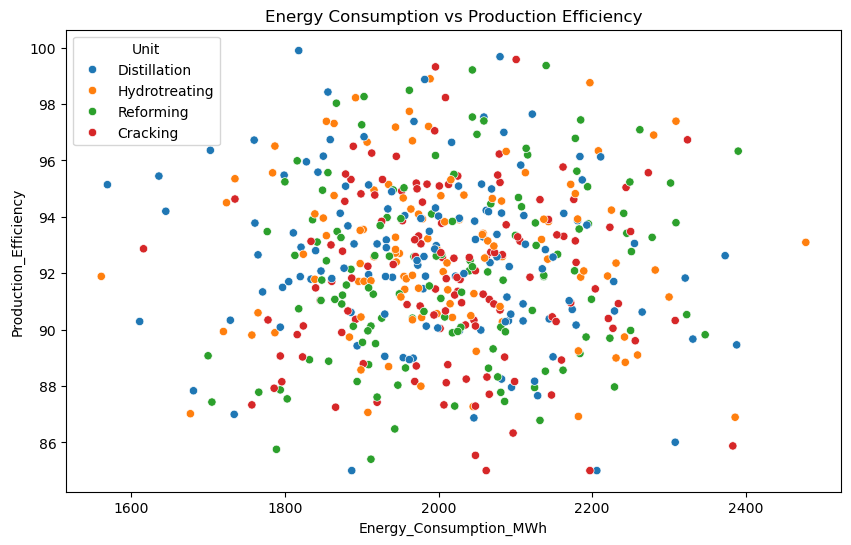

Correlation between Energy Consumption and Production Efficiency: -0.009699653520865907


In [10]:
# Plot Energy consumption vs Production eficiency
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Energy_Consumption_MWh', y='Production_Efficiency', hue='Unit')
plt.title('Energy Consumption vs Production Efficiency')
plt.show()
    
# Correlation
print(f"Correlation between Energy Consumption and Production Efficiency: {df['Energy_Consumption_MWh'].corr(df['Production_Efficiency'])}")

#### 3.4 Predictive maintenance model

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.89      1.00      0.94       131

    accuracy                           0.89       147
   macro avg       0.45      0.50      0.47       147
weighted avg       0.79      0.89      0.84       147



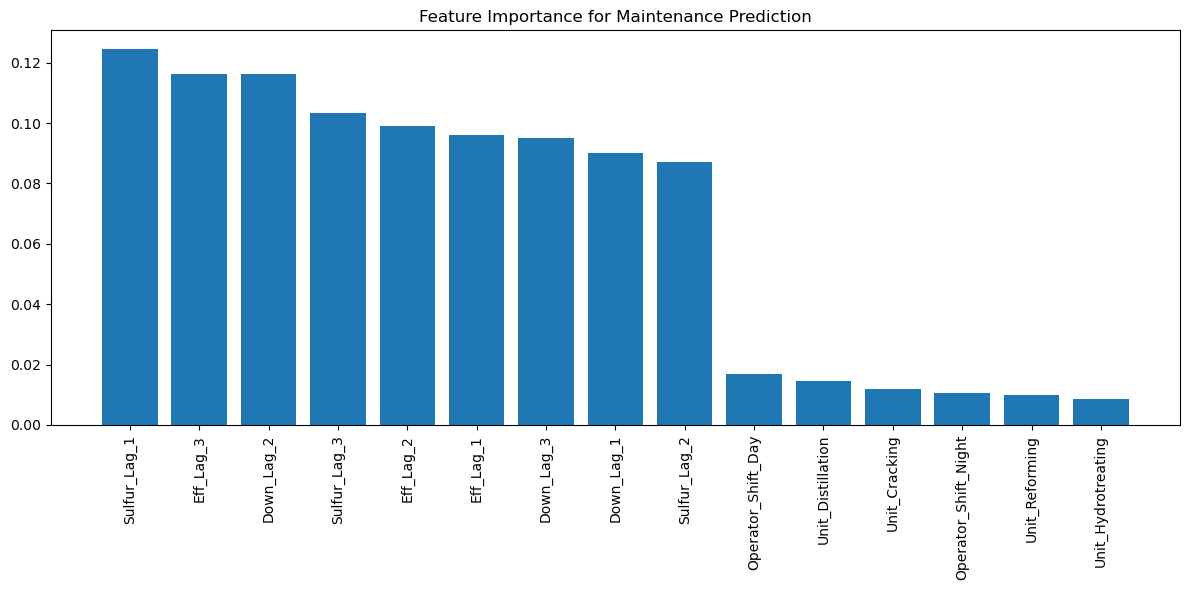

In [11]:
# Prepare data for maintenance prediction
df['Maintenance_Needed'] = (df['Maintenance_Issues'] > 0).astype(int)  # Assuming 0 means no issues

# Create lag features for predictive maintenance
df.sort_values(['Refinery_ID', 'Date'], inplace=True)
for i in [1, 2, 3]:  # Create 1, 2, 3 day lag features
    df[f'Eff_Lag_{i}'] = df.groupby('Refinery_ID')['Production_Efficiency'].shift(i)
    df[f'Down_Lag_{i}'] = df.groupby('Refinery_ID')['Downtime_Hours'].shift(i)
    df[f'Sulfur_Lag_{i}'] = df.groupby('Refinery_ID')['Sulfur_Emission_PPM'].shift(i)

# Drop rows with NA (from lag features)
model_df = df.dropna(subset=['Eff_Lag_3', 'Down_Lag_3', 'Sulfur_Lag_3']).copy()

# Prepare features and target
X = model_df[['Eff_Lag_1', 'Eff_Lag_2', 'Eff_Lag_3', 
              'Down_Lag_1', 'Down_Lag_2', 'Down_Lag_3',
              'Sulfur_Lag_1', 'Sulfur_Lag_2', 'Sulfur_Lag_3',
              'Unit', 'Operator_Shift']]
X = pd.get_dummies(X)
y = model_df['Maintenance_Needed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# Feature importance
features = X.columns
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title('Feature Importance for Maintenance Prediction')
plt.bar(range(len(indices)), importances[indices], align='center')
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

#### 4. Dashboard Creation

In [12]:
# Emission trend dashboard
def create_emission_dashboard():
    # Aggregate data
    emission_trend = df.groupby(['Date', 'Unit', 'Operator_Shift']).agg({
        'Sulfur_Emission_PPM': 'mean',
        'Crude_Processed_BPD': 'sum',
        'Downtime_Hours': 'sum'
    }).reset_index()
    
    # Create plots
    fig1 = px.line(emission_trend, x='Date', y='Sulfur_Emission_PPM', 
                  color='Unit', title='Sulfur Emission Trends by Unit')
    fig2 = px.line(emission_trend, x='Date', y='Sulfur_Emission_PPM', 
                  color='Operator_Shift', title='Sulfur Emission Trends by Shift')
    fig3 = px.scatter(emission_trend, x='Crude_Processed_BPD', y='Sulfur_Emission_PPM',
                     color='Unit', title='Emission vs Throughput')
    
    return fig1, fig2, fig3

fig1, fig2, fig3 = create_emission_dashboard()
fig1.show()
fig2.show()
fig3.show()

#### 5. Operational Performance Benchmarking

In [13]:
# Create benchmarking tool
def performance_benchmarking(refinery_id=None, unit=None, shift=None):
    benchmark_df = df.copy()
    
    if refinery_id:
        benchmark_df = benchmark_df[benchmark_df['Refinery_ID'] == refinery_id]
    if unit:
        benchmark_df = benchmark_df[benchmark_df['Unit'] == unit]
    if shift:
        benchmark_df = benchmark_df[benchmark_df['Operator_Shift'] == shift]
    
    metrics = benchmark_df.agg({
        'Production_Efficiency': ['mean', 'median', 'std'],
        'Downtime_Hours': ['mean', 'median', 'sum'],
        'Sulfur_Emission_PPM': ['mean', 'median', 'max']
    })
    
    # Compare to overall averages
    overall_metrics = df.agg({
        'Production_Efficiency': 'mean',
        'Downtime_Hours': 'mean',
        'Sulfur_Emission_PPM': 'mean'
    })
    
    comparison = pd.DataFrame({
        'Selected': metrics.xs('mean', level=1) if isinstance(metrics.columns, pd.MultiIndex) else metrics.loc['mean'],
        'Overall': overall_metrics
    })
    
    comparison['Difference'] = comparison['Selected'] - comparison['Overall']
    comparison['Pct_Difference'] = (comparison['Difference'] / comparison['Overall']) * 100
    
    return metrics, comparison

# Example usage
unit_metrics, unit_comparison = performance_benchmarking(unit='UnitA')
print("Unit A Metrics:")
print(unit_metrics)
print("\nComparison to Overall Averages:")
print(unit_comparison)

Unit A Metrics:
        Production_Efficiency  Downtime_Hours  Sulfur_Emission_PPM
mean                      NaN             NaN                  NaN
median                    NaN             NaN                  NaN
std                       NaN             NaN                  NaN
sum                       NaN             0.0                  NaN
max                       NaN             NaN                  NaN

Comparison to Overall Averages:
                       Selected    Overall  Difference  Pct_Difference
Production_Efficiency       NaN  92.333851         NaN             NaN
Downtime_Hours              NaN   3.095360         NaN             NaN
Sulfur_Emission_PPM         NaN  49.227220         NaN             NaN


#### 6. Custom Recommendations
Based on the analysis, here are some Python functions to generate recommendations:

In [14]:
def generate_recommendations(df, refinery_id=None, unit=None):
    recommendations = []
    
    # Filter data if specific refinery or unit is selected
    analysis_df = df.copy()
    if refinery_id:
        analysis_df = analysis_df[analysis_df['Refinery_ID'] == refinery_id]
    if unit:
        analysis_df = analysis_df[analysis_df['Unit'] == unit]
    
    # 1. Sulfur emission recommendations
    avg_sulfur = analysis_df['Sulfur_Emission_PPM'].mean()
    if avg_sulfur > df['Sulfur_Emission_PPM'].quantile(0.75):
        recommendations.append(
            f"High sulfur emissions detected (avg: {avg_sulfur:.2f} ppm). "
            "Consider adjusting crude blend ratios or increasing desulfurization unit capacity."
        )
    
    # 2. Downtime recommendations
    avg_downtime = analysis_df['Downtime_Hours'].mean()
    if avg_downtime > df['Downtime_Hours'].quantile(0.75):
        recommendations.append(
            f"Excessive downtime detected (avg: {avg_downtime:.2f} hours). "
            "Review maintenance schedules and operator training programs."
        )
    
    # 3. Production efficiency recommendations
    avg_efficiency = analysis_df['Production_Efficiency'].mean()
    if avg_efficiency < df['Production_Efficiency'].quantile(0.25):
        recommendations.append(
            f"Low production efficiency detected (avg: {avg_efficiency:.2f}%). "
            "Optimize process parameters and check for equipment degradation."
        )
    
    # 4. Shift-specific recommendations
    if not unit and not refinery_id:  # Only for overall analysis
        worst_shift = analysis_df.groupby('Operator_Shift')['Production_Efficiency'].mean().idxmin()
        recommendations.append(
            f"Shift {worst_shift} shows the lowest production efficiency. "
            "\nConsider additional training or resource allocation for this shift."
        )
    
    # 5. Maintenance recommendations
    maintenance_rate = analysis_df['Maintenance_Issues'].mean()
    if maintenance_rate > df['Maintenance_Issues'].quantile(0.75):
        recommendations.append(
            f"High maintenance issues rate detected ({maintenance_rate:.2f}). "
            "Implement predictive maintenance program based on the developed model."
        )
    
    return recommendations

# Generate recommendations
print("Overall Recommendations:")
for rec in generate_recommendations(df):
    print(f"- {rec}")

print("\nUnit-specific Recommendations (Unit A):")
for rec in generate_recommendations(df, unit='UnitA'):
    print(f"- {rec}")

Overall Recommendations:
- Shift Night shows the lowest production efficiency. 
Consider additional training or resource allocation for this shift.

Unit-specific Recommendations (Unit A):
